In [1]:
import glob
import venn
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
import Colors
from matplotlib.patches import Rectangle, Circle
from colour import Color

In [2]:
np.random.seed(174612)

In [3]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [4]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']

# read Lfng tomo data

In [5]:
zdf_L = read_csv('../mGav_Lfng_zscores.tsv', sep = '\t', index_col=0)

In [6]:
zdf_L.columns = [c + '_Lfng' for c in zdf_L.columns]

In [7]:
zdf_L.index = [idx.rsplit('_')[1] for idx in zdf_L.index]

In [8]:
zdf_L['gene'] = zdf_L.index
zdf_L = zdf_L.groupby('gene').aggregate(np.mean)

In [9]:
zdf_L.head()

,0_Lfng,1_Lfng,2_Lfng,3_Lfng,4_Lfng,5_Lfng,6_Lfng,7_Lfng,8_Lfng,9_Lfng,...,34_Lfng,35_Lfng,36_Lfng,37_Lfng,38_Lfng,39_Lfng,40_Lfng,41_Lfng,42_Lfng,43_Lfng
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,-0.188807,2.034960,-0.176123,-0.176123,-0.176123,0.294230,-0.176123,-0.176123,-0.176123,-0.176123,...,-0.176123,-0.176123,-0.176123,-0.176123,-0.166433,-0.176123,-0.176123,1.592118,-0.176123,-0.181197
0610006L08Rik,-0.187805,-0.223868,-0.223868,-0.223868,-0.223868,1.617786,-0.223868,-0.223868,1.420256,-0.223868,...,-0.223868,-0.223868,-0.223868,-0.223868,-0.202241,-0.223868,-0.223868,0.781881,1.375330,-0.209443
0610009B22Rik,-0.612130,0.988285,0.628839,-0.270055,0.526624,-0.152027,0.954368,-0.011101,0.230712,-0.093047,...,-0.119287,-0.263682,-0.058297,-0.887319,-0.244843,0.358613,0.811372,0.115142,-0.598511,0.315795
0610009E02Rik,-0.794478,-0.389908,-0.509629,-0.393365,-0.328879,-0.561543,-0.332135,-0.440774,-0.284435,-0.280780,...,2.080390,0.500214,0.396961,0.936369,0.099152,0.103562,-0.260717,-0.314577,-0.066575,-0.738610
0610009L18Rik,-0.396585,1.501066,0.209504,0.156640,-0.498049,-0.293531,0.321023,-0.236410,1.213289,-0.388860,...,-0.498049,-0.498049,-0.242523,-0.270793,-0.466946,-0.238607,-0.167349,-0.128608,0.863412,0.333198


In [10]:
gene_corr_L = read_csv('../results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [11]:
gene_corr_L.index = [idx.rsplit('_')[1] for idx in gene_corr_L.index]

In [12]:
gene_corr_L['gene'] = gene_corr_L.index
gene_corr_L = gene_corr_L.groupby('gene').aggregate(max)

In [13]:
gene_corr_L.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
gene,,,,,,,,,
0610005C13Rik,-0.036554,0.604621,0.849729,-0.022763,0.569014,0.878416,-0.038298,0.601620,0.885385
0610006L08Rik,-0.035729,0.603821,0.849729,-0.045628,0.639628,0.878416,0.256705,0.044709,0.316715
0610009B22Rik,-0.176745,0.895279,0.924007,0.132456,0.160732,0.664329,-0.409501,0.998100,0.998602
0610009E02Rik,0.379359,0.002300,0.030439,0.059747,0.337768,0.878416,0.380250,0.003501,0.046775
0610009L18Rik,-0.066883,0.684037,0.849729,0.052861,0.358572,0.878416,0.299400,0.022104,0.194519


In [14]:
pvcols = [c for c in gene_corr_L.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_L = gene_corr_L.index[gene_corr_L.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [15]:
gcL = gene_corr_L[pvcols].mean(axis=1)

# read E14 gastruloid data

In [16]:
zdf_E = read_csv('../../E14-mGstl-tomo/mGav_E14_zscores.tsv', sep = '\t', index_col=0)

In [17]:
zdf_E.columns = [c + '_E14' for c in zdf_E.columns]

In [18]:
zdf_E.index = [idx.rsplit('_')[1] for idx in zdf_E.index]

In [19]:
zdf_E['gene'] = zdf_E.index
zdf_E = zdf_E.groupby('gene').aggregate(np.mean)

In [20]:
zdf_E.head()

,0_E14,1_E14,2_E14,3_E14,4_E14,5_E14,6_E14,7_E14,8_E14,9_E14,10_E14,11_E14,12_E14,13_E14
gene,,,,,,,,,,,,,,
0610009B22Rik,0.473757,0.213415,-0.029172,-0.414105,-0.573906,0.078347,-0.186189,0.671578,-0.236564,0.146173,-0.306602,-0.241930,0.207648,0.042823
0610009E02Rik,-0.652906,-0.330957,-0.235046,0.129279,0.001926,0.210943,1.056104,0.729677,-0.279825,-0.042147,0.119801,0.031393,-0.545713,-0.339888
0610009L18Rik,-0.057287,-0.164612,0.166930,-0.269565,-0.243485,0.380045,0.188397,-0.312148,-0.110156,0.052361,0.167611,0.549429,0.528920,-0.572143
0610009O20Rik,0.102047,0.657252,-0.125989,-0.025298,-0.675306,-0.111463,0.007432,-0.474294,-0.034650,-0.274156,0.106623,0.406431,0.003990,0.178172
0610010F05Rik,-0.530842,-0.202795,-0.049129,0.586434,0.053791,0.003117,-0.042473,-0.031052,-0.182153,-0.207457,-0.016354,0.270105,0.328187,0.256241


In [21]:
gene_corr_E = read_csv('../../E14-mGstl-tomo/results/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [22]:
gene_corr_E.index = [idx.rsplit('_')[1] for idx in gene_corr_E.index]

In [23]:
gene_corr_E['gene'] = gene_corr_E.index
gene_corr_E = gene_corr_E.groupby('gene').aggregate(max)

In [24]:
gene_corr_E.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(0, 3)","pv_(0, 3)","adj-pv_(0, 3)","corr_(0, 4)",...,"adj-pv_(1, 4)","corr_(2, 3)","pv_(2, 3)","adj-pv_(2, 3)","corr_(2, 4)","pv_(2, 4)","adj-pv_(2, 4)","corr_(3, 4)","pv_(3, 4)","adj-pv_(3, 4)"
gene,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.108737,0.359972,0.799886,0.128350,0.323365,0.844030,0.243623,0.192739,0.627447,0.476018,...,0.956262,0.387067,0.093319,0.556105,-0.476500,0.954091,0.988804,-0.021703,0.573615,1.000000
0610009E02Rik,0.766689,0.000500,0.021972,0.247794,0.184737,0.659841,0.201828,0.240748,0.697360,-0.203720,...,0.601766,0.270836,0.186337,0.743218,-0.068348,0.588018,0.940262,0.037213,0.387177,0.913354
0610009L18Rik,0.294085,0.147730,0.550195,0.226783,0.207542,0.699699,-0.206956,0.772254,0.955630,0.082523,...,0.916819,0.121126,0.345969,0.897671,0.292821,0.156131,0.660178,-0.002147,0.514003,0.991739
0610009O20Rik,0.430464,0.061912,0.384485,0.000885,0.489398,0.945054,0.441959,0.049310,0.319190,-0.080532,...,0.956262,-0.348553,0.894479,0.986038,0.073518,0.395379,0.926366,-0.039581,0.626625,1.000000
0610010F05Rik,-0.053632,0.594619,0.938225,0.277525,0.157131,0.611321,0.147345,0.302360,0.763761,0.293500,...,0.996476,-0.433035,0.941488,0.992596,0.862057,0.000000,0.000000,-0.317487,0.996499,1.000000


In [25]:
pvcols = [c for c in gene_corr_E.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 5
genelist_E = gene_corr_E.index[gene_corr_E.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [26]:
gcE = gene_corr_E[pvcols].mean(axis=1)

# read mouse PSM data

In [27]:
zdf_PSM = read_csv('../../microarray_GSE39615/averagePSM_zscores.tsv', sep= '\t', index_col=0)

In [28]:
zdf_PSM.columns = [c + '_PSM' for c in zdf_PSM.columns]

In [29]:
zdf_PSM.head()

,0_PSM,1_PSM,2_PSM,3_PSM,4_PSM,5_PSM,6_PSM
gene,,,,,,,
Ndufv2,0.922359,-0.481245,0.491429,-0.461798,0.580223,-0.370901,-0.680067
Nedd4,0.680646,0.690637,-0.342777,-0.021506,-0.785372,-0.308882,0.087254
Ppp2r1a,0.387639,-0.050110,-0.216261,0.710257,-1.389669,-0.120613,0.678756
Nars,-0.357373,0.409796,-0.918264,-1.224433,0.726153,1.252813,0.111308
Hdac1,0.514926,-0.223679,-0.375281,0.292037,-0.874960,-0.689551,1.356507


In [30]:
file = '../../microarray_GSE39615/results/geneCorrelations_PSM.tsv'
gene_corr_PSM = read_csv(file, sep = '\t', index_col=0)

In [31]:
gene_corr_PSM.head()

,"corr_(0, 1)","pv_(0, 1)","adj-pv_(0, 1)","corr_(0, 2)","pv_(0, 2)","adj-pv_(0, 2)","corr_(1, 2)","pv_(1, 2)","adj-pv_(1, 2)"
0610005C13Rik,-0.247821,0.703641,0.869171,-0.283586,0.729046,0.871289,0.467298,0.144529,0.465318
0610006L08Rik,0.433991,0.164533,0.501929,-0.584178,0.920084,0.960225,0.143380,0.373175,0.682424
0610007P14Rik,0.556039,0.098920,0.416186,0.467039,0.144729,0.438160,0.145303,0.371974,0.682212
0610009B22Rik,0.112384,0.408782,0.717277,0.067496,0.442388,0.718272,0.752753,0.020304,0.168208
0610009L18Rik,-0.553813,0.899680,0.946693,0.353428,0.213743,0.515062,-0.058597,0.551010,0.802980


In [32]:
pvcols = [c for c in gene_corr_PSM.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_PSM = gene_corr_PSM.index[gene_corr_PSM.apply(lambda x: sum(x[pvcols] < pvth), axis = 1) >= nth]

In [33]:
gcPSM = gene_corr_PSM[pvcols].mean(axis=1)

# clustering

In [34]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [35]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

# Compare the three at the same time

In [43]:
gene_all = list(set(list(genelist_E)+list(genelist_PSM)+list(genelist_L)))
gene_all = [g for g in gene_all if g in zdf_E.index and g in zdf_PSM.index and g in zdf_L.index
                  and g in gcE.index and g in gcPSM.index and g in gcL.index]
len(gene_all), 5*np.sqrt(len(gene_all))


(3086, 277.758888246623)

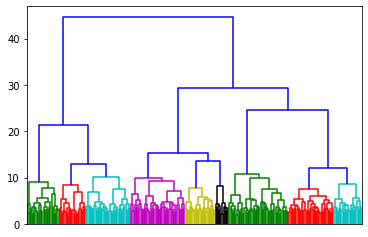

In [44]:
somhcl_all_df = comboCluster(mergeDfs([zdf_E, zdf_L, zdf_PSM]), gene_all, cth=11, gridheight=29, gridwidth=10)


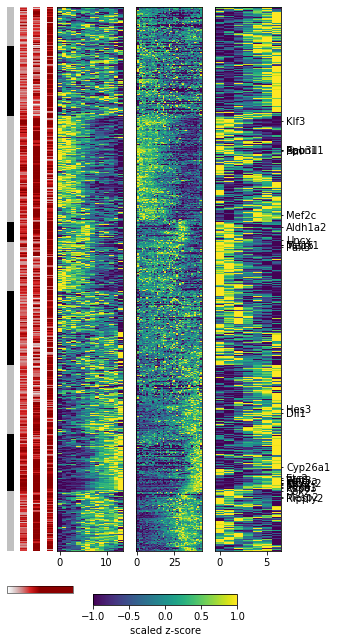

In [45]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_all_df
dfs = [zdf_E, zdf_L, zdf_PSM]
gcs = [gcE, gcL, gcPSM]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g in g_annotate])
ax[-1].set_yticklabels([g for g in gene_order[::-1] if g in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -8*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

npoints = 100
xra = np.linspace(0,1,npoints)
gcolors = list(Color('darkred').range_to(Color('white'),npoints-1))
colors = {(xra[i],xra[i+1]): gcolors[i].hex_l for i in range(npoints-1)}
for i, gc in enumerate(gcs):
    x0 = (-6+2*i)*dx
    y0 = len(hcl)-0.5
    n = 0
    for i, g in enumerate(gene_order):
        c = colors[[i for i in colors if i[0]<=gc.loc[g]<i[1]][0]]
        rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
        ax[0].add_patch(rect)
        y0 -= 1
    
dxx = 0
x0 = -8*dx
x1 = -3*dx
dL = 1.0*(x1-x0)/len(colors)
for i, c in enumerate(list(colors.keys())[::-1]):
    rect = Rectangle((x0+dxx,len(gene_order)+200), dxx+dL, 40, edgecolor = None, facecolor = colors[c], clip_on=False)
    ax[0].add_patch(rect)
    dxx += dL
rect = Rectangle((x0,len(gene_order)+200), 2*dxx-dL, 40, edgecolor = 'k', fill = False, clip_on=False, lw = 0.5)
ax[0].add_patch(rect)

plt.savefig('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_allgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_allgenes.tsv', sep = '\t')

plt.show()



In [46]:
! mkdir ../results/comparison_LfngE14_PSM/GOanalysis/

mkdir: ../results/comparison_LfngE14_PSM/GOanalysis/: File exists


In [47]:
fout = '../results/comparison_LfngE14_PSM/GOanalysis/population.tsv'
pd.DataFrame(pd.Series([idx for idx in somhcl_all_df.index])).to_csv(fout, sep = '\t', index = None, header = None)

In [48]:
for cl in set(somhcl_all_df['hcl']):
    fout = '../results/comparison_LfngE14_PSM/GOanalysis/cl' + str(cl).zfill(2) + '.tsv'
    pd.DataFrame(pd.Series([idx for idx in somhcl_all_df[somhcl_all_df['hcl']==cl].index])).to_csv(fout, sep = '\t', index = None, header = None)
    

# Compare only reproducible genes between the three samples

In [49]:
cnt = Counter(list(genelist_E)+list(genelist_PSM)+list(genelist_L))
repr_genes = [g for g in cnt if cnt[g]==3]
len(repr_genes), 5*np.sqrt(len(repr_genes))

(239, 77.29812416870153)

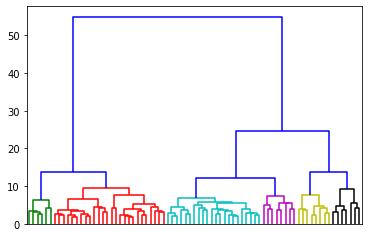

In [50]:
somhcl_allRepr_df = comboCluster(mergeDfs([zdf_E, zdf_L, zdf_PSM]), repr_genes, cth=11, gridheight=9, gridwidth=9)


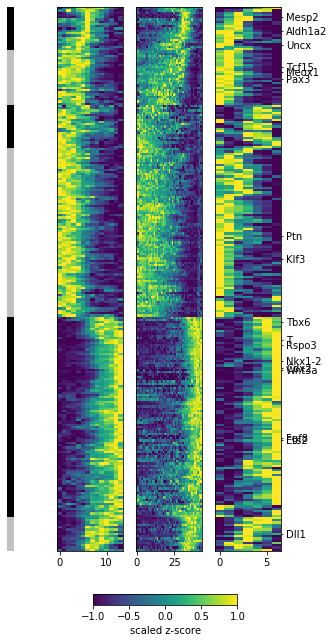

In [51]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_allRepr_df
dfs = [zdf_E, zdf_L, zdf_PSM]
gcs = [gcE, gcL, gcPSM]
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g in g_annotate])
ax[-1].set_yticklabels([g for g in gene_order[::-1] if g in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -8*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_ReprGenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_ReprGenes.tsv', sep = '\t')

plt.show()



In [52]:
new_order = {1:0,
             0:1,
             5:2,
             4:3,
             2:4,
             3:5}

In [53]:
somhcl_allRepr_df['new-hcl'] = somhcl_allRepr_df.apply(lambda x: new_order[x['hcl']], axis = 1)

In [54]:
somhcl_allRepr_df.head()

,som,hcl,new-hcl
gene,,,
2010111I01Rik,73,1,0
2610528A11Rik,71,0,1
6430573F11Rik,40,3,5
AW551984,58,1,0
Abca1,34,5,2


In [55]:
somhcl_allRepr_df.columns = ['som', 'hcl-old', 'hcl']

In [57]:
somhcl_allRepr_df['neg-som'] = -somhcl_allRepr_df['som']

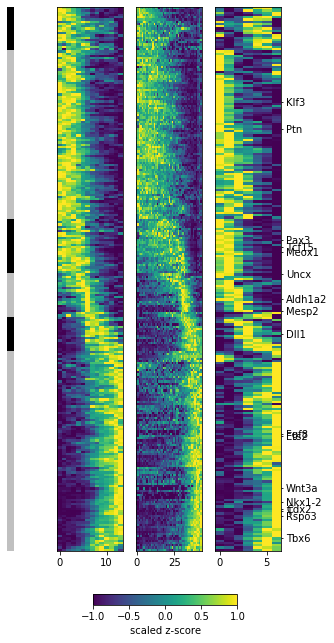

In [58]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize = (4,10))

hcl = somhcl_allRepr_df
dfs = [zdf_E, zdf_L, zdf_PSM]
gcs = [gcE, gcL, gcPSM]
gene_order = hcl.sort_values(by=['hcl','neg-som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate(dfs):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g in g_annotate])
ax[-1].set_yticklabels([g for g in gene_order[::-1] if g in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(dfs[0].columns)
x0 = -8*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_ReprGenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_LfngE14_PSM/heatmap_E14LfngPSM_ReprGenes.tsv', sep = '\t')

plt.show()

